# Wetland histograms

**Background**

**What does this notebook do?** This notebook generates histograms of raster properties for wetland and non-wetland regions in Queensland.

**Date**: Aug 2020.

**Author**: Matthew Alger

## Setup

Set up the notebook and load the data.

In [174]:
import functools
import os
import sys
import datacube
from datacube.storage.masking import make_mask
import datacube.utils.cog
import geopandas as gpd
import ipyleaflet
from IPython.display import display
import ipywidgets as widgets
import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import odc.ui
from odc.ui import with_ui_cbk
import rasterio.features
import rasterio.mask
from shapely.geometry import shape
from shapely.validation import explain_validity
import skimage.color as colour
import skimage.io
from tqdm.notebook import tqdm
import xarray

sys.path.append('../Scripts')
from dea_dask import create_local_dask_cluster
from dea_datahandling import load_ard, array_to_geotiff
from dea_plotting import rgb

In [11]:
tcw_conf = '/g/data/r78/datacube_stats/ls_tcw_percentiles/vmn547_cog_dev.conf'
dc = datacube.Datacube(config=tcw_conf)

In [12]:
wetlands = gpd.read_file('/g/data/r78/ma6611/Queensland_dominant_wetland_areas_22042020.shp')

In [13]:
tiles = gpd.read_file('QLDTestTiles.shp')

In [14]:
validity = wetlands.geometry.apply(lambda k: explain_validity(k) if k is not None else None)

In [15]:
invalid = validity != 'Valid Geometry'

In [16]:
# Fix invalid geometries.
fixed_wetlands = wetlands[invalid].geometry.buffer(0)
wetlands_original = wetlands
wetlands = wetlands.copy()
wetlands.loc[invalid, 'geometry'] = fixed_wetlands

## Calculate histograms

In [17]:
sampled_wetlands = wetlands.geometry.intersection(tiles.unary_union)

In [18]:
wetlands = wetlands[~sampled_wetlands.geometry.is_empty]
wetlands.loc[:, 'geometry'] = sampled_wetlands[~sampled_wetlands.geometry.is_empty]

In [19]:
# Here's some ways to get the "non-wetlands" regions that we have tiles for.
# Super super slow! Don't do this.
# Better approach is to load the raster images that we have and then mask the wetlands.

# sampled_nonwetlands = tiles.copy()
# for i in tqdm(range(len(sampled_wetlands))):
#     sampled_nonwetlands = sampled_nonwetlands.difference(wetlands.iloc[i])

# sampled_nonwetlands = gpd.overlay(tiles, wetlands, how='difference')

In [28]:
def get_tcw(tile_label):
    tif_path_base = '/g/data/r78/datacube_stats/TCW_stats/demo_tiles/output_qld_wetness/LS_TCW_PC_{}_1986_2020_summary.tif'
    tif_path = tif_path_base.format(tile_label.replace(',', '_'))
    da = xarray.open_rasterio(tif_path)
    return da

def get_tcg(tile_label):
    tif_path_base = '/g/data/r78/datacube_stats/TCW_stats/demo_tiles/output_qld_greenness/LS_TCG_PC_{}_1986_2020_summary.tif'
    tif_path = tif_path_base.format(tile_label.replace(',', '_'))
    da = xarray.open_rasterio(tif_path)
    return da

def make_wetland_mask(da):
    raster_wetland = rasterio.features.rasterize(shapes=wetlands.buffer(0),
                                                 out_shape=da.y.shape + da.x.shape,
                                                 all_touched=False,
                                                 default_value=1,
                                                 fill=0,
                                                 transform=da.geobox.transform)
    return raster_wetland.astype(bool)

In [36]:
def get_tc_data(tile_label, tc='w', band=3, bins=None) -> ('wetland', 'nonwetland'):
    if tc == 'w':
        get = get_tcw
    elif tc == 'g':
        get = get_tcg
    else:
        raise NotImplementedError(f'Unsupported TC type: {tc} (supported: w, g)')

    da = get(tile_label)
    # Rasterise this tile of wetlands so we can quickly mask.
    wetlands_mask = make_wetland_mask(da)
    # Apply the mask and get the TC data.
    tc_data = da.isel(band=band).values
    nodata = tc_data == da.nodatavals[band]
    tc_data_w = tc_data[wetlands_mask & ~nodata]
    tc_data_nw = tc_data[~wetlands_mask & ~nodata]
    
    if bins is None:
        # Just return the data. Big!
        return tc_data_w, tc_data_nw
    
    # Return a histogram of the data.
    hist_wetland, bin_edges = np.histogram(tc_data_w, bins=bins)
    assert (bin_edges == bins).all()
    hist_nonwetland, bin_edges = np.histogram(tc_data_nw, bins=bins)
    return (hist_wetland, hist_nonwetland)

In [32]:
bins = np.linspace(-4000, 4000, 120)
hist_wetland = np.zeros(len(bins) - 1, dtype=int)
hist_nonwetland = np.zeros(len(bins) - 1, dtype=int)
for tile in tqdm(tiles.itertuples(), total=len(tiles)):
    hist_wetland_, hist_nonwetland_ = get_tc_data(tile.label, tc='w', band=3, bins=bins)
    hist_wetland += hist_wetland_
    hist_nonwetland += hist_nonwetland_

In [33]:
px_to_km2 = 0.0001 # 10 m x 10 m -> 100 m^2 = 0.0001 km^2

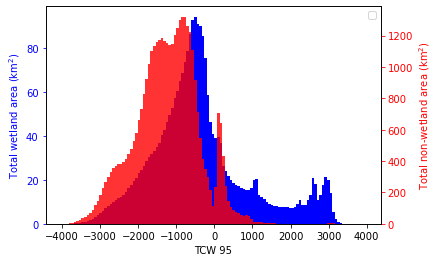

In [34]:
ax = plt.subplot(1, 1, 1)
ax.bar(bins[:-1], hist_wetland * px_to_km2, width=bins[1] - bins[0], color='blue')
ax.set_xlabel('TCW 95')
ax.set_ylabel('Total wetland area (km$^2$)', fontdict={'color': 'blue'})
ax.tick_params(axis='y', colors='blue')
ax2 = ax.twinxAttributeError: 'Rectangle' object has no attribute 'do_3d_projection'()
ax2.bar(bins[:-1], hist_nonwetland * px_to_km2, width=bins[1] - bins[0], color='red', alpha=0.8)
ax2.set_ylabel('Total non-wetland area (km$^2$)', fontdict={'color': 'red'})
ax2.tick_params(axis='y', colors='red')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

In [39]:
bins = np.linspace(-4000, 4000, 120)
hist_wetland = np.zeros(len(bins) - 1, dtype=int)
hist_nonwetland = np.zeros(len(bins) - 1, dtype=int)
for tile in tqdm(tiles.itertuples(), total=len(tiles)):
    try:
        hist_wetland_, hist_nonwetland_ = get_tc_data(tile.label, tc='g', band=1, bins=bins)
    except:
        continue
    hist_wetland += hist_wetland_
    hist_nonwetland += hist_nonwetland_

In [450]:
def plot_wetlands_histogram(hist_wetland, hist_nonwetland, xlabel, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    ax.bar(bins[:-1], hist_wetland * px_to_km2, width=bins[1] - bins[0], color='blue')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Total wetland area (km$^2$)', fontdict={'color': 'blue'})
    ax.tick_params(axis='y', colors='blue')
    ax2 = ax.twinx()
    ax2.bar(bins[:-1], hist_nonwetland * px_to_km2, width=bins[1] - bins[0], color='red', alpha=0.8)
    ax2.set_ylabel('Total non-wetland area (km$^2$)', fontdict={'color': 'red'})
    ax2.tick_params(axis='y', colors='red')

#     lines, labels = ax.get_legend_handles_labels()
#     lines2, labels2 = ax2.get_legend_handles_labels()
#     ax2.legend(lines + lines2, labels + labels2, loc=0)

    if ax is None:
        return fig

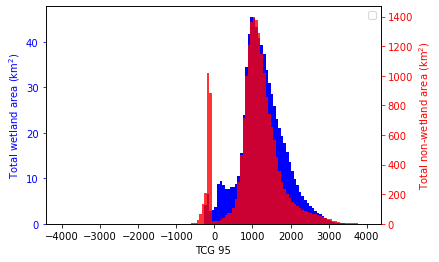

In [49]:
plot_wetlands_histogram(hist_wetland, hist_nonwetland, 'TCG 95');

In [41]:
ibins = np.linspace(-4000, 4000, 120)
hist_wetland_green_50 = np.zeros(len(bins) - 1, dtype=int)
hist_nonwetland_green_50 = np.zeros(len(bins) - 1, dtype=int)
for tile in tqdm(tiles.itertuples(), total=len(tiles)):
    try:
        hist_wetland_, hist_nonwetland_ = get_tc_data(tile.label, tc='g', band=1, bins=bins)
    except:
        continue
    hist_wetland_green_50 += hist_wetland_
    hist_nonwetland_green_50 += hist_nonwetland_

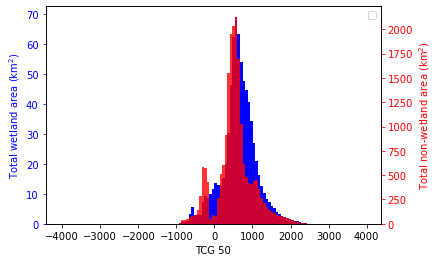

In [51]:
plot_wetlands_histogram(hist_wetland_green_50, hist_nonwetland_green_50, 'TCG 50');

In [59]:
def get_tc_data_2d(tile_label, tcs=('w', 'g'), bands=(3, 1), bins=None) -> ('wetland', 'nonwetland'):
    for tc in tcs:
        if tc not in 'wg':
            raise NotImplementedError(f'Unsupported TC type: {tc} (supported: w, g)')

    gets = {'w': get_tcw, 'g': get_tcg}
    
    data_w = []
    data_nw = []
    for tc, band in zip(tcs, bands):
        get = gets[tc]
        da = get(tile_label)
        # Rasterise this tile of wetlands so we can quickly mask.
        wetlands_mask = make_wetland_mask(da)
        # Apply the mask and get the TC data.
        tc_data = da.isel(band=band).values
        nodata = tc_data == da.nodatavals[band]
        tc_data_w = tc_data[wetlands_mask & ~nodata]
        tc_data_nw = tc_data[~wetlands_mask & ~nodata]
        data_w.append(tc_data_w)
        data_nw.append(tc_data_nw)
    
    if bins is None:
        # Just return the data. Big!
        return data_w, data_nw

    # Return a histogram of the data.
    hist_wetland, bin_edges_x, bin_edges_y = np.histogram2d(data_w[0], data_w[1], bins=bins)
    hist_nonwetland, bin_edges_x, bin_edges_y = np.histogram2d(data_nw[0], data_nw[1], bins=bins)
    return (hist_wetland, hist_nonwetland)

In [84]:
bins_w = np.linspace(-4000, 4000, 120)
bins_g = np.linspace(-1000, 3000, 120)

hist_wetland_2d = np.zeros((len(bins_w) - 1, len(bins_g) - 1))
hist_nonwetland_2d = np.zeros_like(hist_wetland_2d)

for tile in tqdm(tiles.itertuples(), total=len(tiles)):
    try:
        hist_wetland_2d_, hist_nonwetland_2d_ = get_tc_data_2d(tile.label, bins=(bins_w, bins_g), bands=(3, 0))
    except:
        # no data yet
        continue
    hist_wetland_2d += hist_wetland_2d_
    hist_nonwetland_2d += hist_nonwetland_2d_

RasterioIOError: /g/data/r78/datacube_stats/TCW_stats/demo_tiles/output_qld_greenness/LS_TCG_PC_7_-28_1986_2020_summary.tif: No such file or directory

(-1000.0, 3000.0)

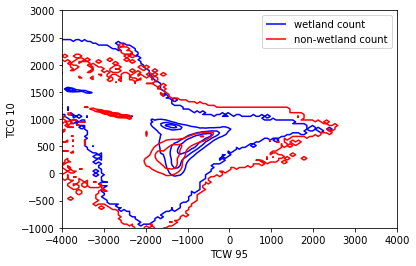

In [86]:
hw = plt.contour(bins_w[:-1], bins_g[:-1], hist_wetland_2d, colors='blue')
hnw = plt.contour(bins_w[:-1], bins_g[:-1], hist_nonwetland_2d, colors='red')
plt.legend([hw.collections[0], hnw.collections[0]], ['wetland count', 'non-wetland count'])
plt.xlabel('TCW 95')
plt.ylabel('TCG 10')
plt.xlim(bins_w.min(), bins_w.max())
plt.ylim(bins_g.min(), bins_g.max())

In [ ]:
bins = np.linspace(-4000, 4000, 120)
hist_wetland_green_10 = np.zeros(len(bins) - 1, dtype=int)
hist_nonwetland_green_10 = np.zeros(len(bins) - 1, dtype=int)
for tile in tqdm(tiles.itertuples(), total=len(tiles)):
    try:
        hist_wetland_, hist_nonwetland_ = get_tc_data(tile.label, tc='g', band=0, bins=bins)
    except:
        continue
    hist_wetland_green_10 += hist_wetland_
    hist_nonwetland_green_10 += hist_nonwetland_

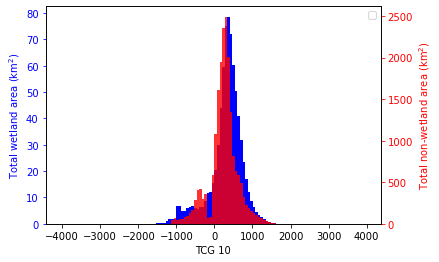

In [79]:
plot_wetlands_histogram(hist_wetland_green_10, hist_nonwetland_green_10, 'TCG 10');

How does the TCW histogram vary with Koppen climate zone? We use the Koppen maps from Beck, H.E., N.E. Zimmermann, T.R. McVicar, N. Vergopolan, A. Berg, E.F. Wood: Present and future Köppen-Geiger climate classification maps at 1-km resolution, Scientific Data 5:180214, doi:10.1038/sdata.2018.214 (2018).


In [310]:
# koppen = rasterio.open('/g/data/r78/ma6611/Beck_KG_V1_present_0p0083.tif')  # 1km resolution

In [355]:
koppen = xarray.open_rasterio('/g/data/r78/ma6611/Beck_KG_V1_present_0p0083.tif')  # 1km resolution

In [168]:
climate_zone_labels = {
    1: 'Af',
    2: 'Am',
    3: 'Aw',
    4: 'BWh',
    5: 'BWk',
    6: 'BSh',
    7: 'BSk',
    8: 'Csa',
    9: 'Csb',
    10: 'Csc',
    11: 'Cwa',
    12: 'Cwb',
    13: 'Cwc',
    14: 'Cfa',
    15: 'Cfb',
    16: 'Cfc',
    17: 'Dsa',
    18: 'Dsb',
    19: 'Dsc',
    20: 'Dsd',
    21: 'Dwa',
    22: 'Dwb',
    23: 'Dwc',
    24: 'Dwd',
    25: 'Dfa',
    26: 'Dfb',
    27: 'Dfc',
    28: 'Dfd',
    29: 'ET',
    30: 'EF',koppen_hist_nonwetland_wet_95[zone]koppen_hist_nonwetland_wet_95[zone]
    0: 'Ocean',
}

In [424]:
def get_koppen_tile(da):
    dest = np.zeros(da.shape[1:])
    src_transform = rasterio.transform.Affine(*koppen.transform)
    koppen_tile = rasterio.warp.reproject(
        koppen.values, dest, src_crs=koppen.crs, dst_crs='EPSG:3577', src_transform=src_transform,
        dst_transform=da.transform)
    return koppen_tile[0].astype(int)

In [415]:
def get_tc_data_and_mask(tile_label, tc='w', band=3) -> ('array', 'wetland mask', 'nonwetland mask'):
    if tc == 'w':
        get = get_tcw
    elif tc == 'g':
        get = get_tcg
    else:
        raise NotImplementedError(f'Unsupported TC type: {tc} (supported: w, g)')

    da = get(tile_label)
    # Rasterise this tile of wetlands so we can quickly mask.
    wetlands_mask = make_wetland_mask(da)
    # Apply the mask and get the TC data.
    tc_data = da.isel(band=band).values
    nodata = tc_data == da.nodatavals[band]
    return da, wetlands_mask & ~nodata, ~wetlands_mask & ~nodata

In [431]:
bins = np.linspace(-4000, 4000, 120)

koppen_hist_wetland_wet_95 = {}
koppen_hist_nonwetland_wet_95 = {}

for i, tile in tqdm(tiles.iterrows(), total=len(tiles)):
    da, mask_w, mask_nw = get_tc_data_and_mask(tile.label, tc='w', band=3)
    
    # Split up by Koppen climate zone.
    koppen_tile = xarray.DataArray(get_koppen_tile(da), coords=(da.y, da.x))
    koppen_vals = np.unique(koppen_tile.values)
    
    for v in koppen_vals:
        if v not in koppen_hist_wetland_wet_95:
            koppen_hist_wetland_wet_95[v] = np.zeros(len(bins) - 1)
            koppen_hist_nonwetland_wet_95[v] = np.zeros_like(koppen_hist_wetland_wet_95[v])

        koppen_hist_wetland_wet_95[v] += np.histogram(da.isel(band=3).values[mask_w & (koppen_tile == v)], bins)[0]
        koppen_hist_nonwetland_wet_95[v] += np.histogram(da.isel(band=3).values[mask_nw & (koppen_tile == v)], bins)[0]

In [445]:
# 3D plot: cool, but hard to read for lots of zones.
# %matplotlib widget
# n_zones = len(koppen_hist_wetland_wet_95)
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# for i, zone in enumerate(sorted(koppen_hist_wetland_wet_95)):
#     ax.bar(bins[:-1], koppen_hist_wetland_wet_95[zone] / (koppen_hist_wetland_wet_95[zone].max() + 1),
#            width=bins[1] - bins[0], color='blue', alpha=0.5, zs=i, zdir='y', edgecolor='None')
#     ax.bar(bins[:-1], koppen_hist_nonwetland_wet_95[zone] / (koppen_hist_nonwetland_wet_95[zone].max() + 1),
#            width=bins[1] - bins[0], color='red', alpha=0.5, zs=i + 0.1, zdir='y', edgecolor='None')
# ax.set_xlabel('TCW 95')
# ax.set_zlabel('Density')
# ax.set_ylabel('Köppen climate zone')
# ticks = ax.set_yticks(range(n_zones))
# ax.set_yticklabels([climate_zone_labels[k] for k in sorted(koppen_hist_wetland_wet_95)])
# plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

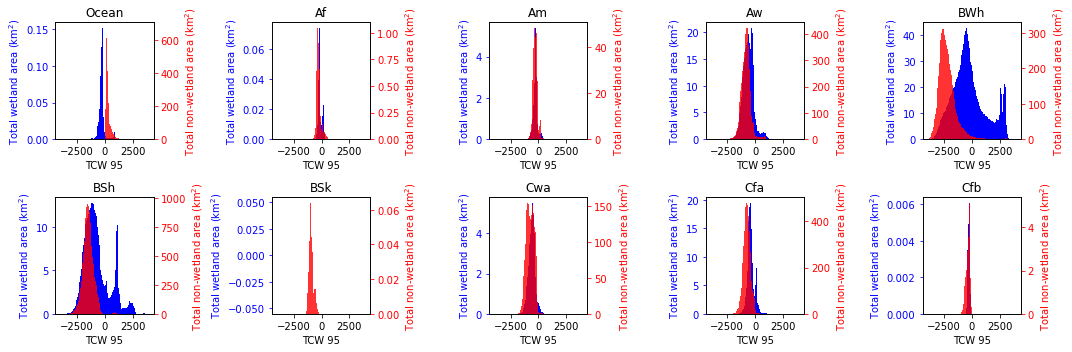

In [451]:
%matplotlib inline
n_zones = len(koppen_hist_wetland_wet_95)
assert n_zones == 10  # Just for the subplot shapes :)
fig = plt.figure(figsize=(15, 5))
for i, zone in enumerate(sorted(koppen_hist_wetland_wet_95)):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title(climate_zone_labels[zone])
    plot_wetlands_histogram(koppen_hist_wetland_wet_95[zone], koppen_hist_nonwetland_wet_95[zone], 'TCW 95', ax=ax)
plt.tight_layout()

In [454]:
bins = np.linspace(-4000, 4000, 120)

koppen_hist_wetland_green_50 = {}
koppen_hist_nonwetland_green_50 = {}

for i, tile in tqdm(tiles.iterrows(), total=len(tiles)):
    try:
        da, mask_w, mask_nw = get_tc_data_and_mask(tile.label, tc='g', band=1)
    except:  # No data yet
        continue
    
    # Split up by Koppen climate zone.
    koppen_tile = xarray.DataArray(get_koppen_tile(da), coords=(da.y, da.x))
    koppen_vals = np.unique(koppen_tile.values)
    
    for v in koppen_vals:
        if v not in koppen_hist_wetland_green_50:
            koppen_hist_wetland_green_50[v] = np.zeros(len(bins) - 1)
            koppen_hist_nonwetland_green_50[v] = np.zeros_like(koppen_hist_wetland_green_50[v])

        koppen_hist_wetland_green_50[v] += np.histogram(da.isel(band=3).values[mask_w & (koppen_tile == v)], bins)[0]
        koppen_hist_nonwetland_green_50[v] += np.histogram(da.isel(band=3).values[mask_nw & (koppen_tile == v)], bins)[0]

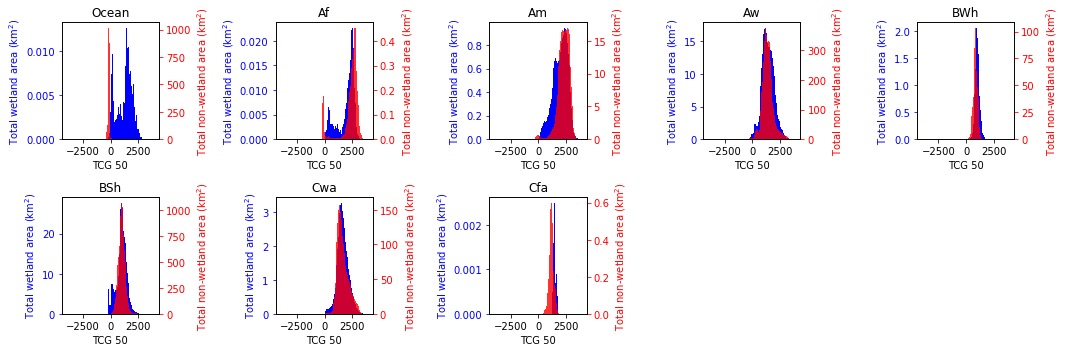

In [458]:
%matplotlib inline
n_zones = len(koppen_hist_wetland_green_50)
assert n_zones < 10  # It's 8 in the tiles already done
fig = plt.figure(figsize=(15, 5))
for i, zone in enumerate(sorted(koppen_hist_wetland_green_50)):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title(climate_zone_labels[zone])
    plot_wetlands_histogram(koppen_hist_wetland_green_50[zone], koppen_hist_nonwetland_green_50[zone], 'TCG 50', ax=ax)
plt.tight_layout()